
## Homework 1 of CS330


In [ ]:
import os
import time
from google_drive_downloader import GoogleDriveDownloader as gdd

# Need to download the Omniglot dataset -- DON'T MODIFY THIS CELL
if not os.path.isdir('./omniglot_resized'):
    gdd.download_file_from_google_drive(file_id='1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI',
                                        dest_path='./omniglot_resized.zip',
                                        unzip=True)
    
assert os.path.isdir('./omniglot_resized')

Unzipping...Done.


## Problem 1

In [ ]:
import numpy as np
import os
import random
import tensorflow as tf
from scipy import misc


def get_images(paths, labels, nb_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths: A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    if nb_samples is not None:
        sampler = lambda x: random.sample(x, nb_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(path, image))
                     for i, path in zip(labels, paths)
                     for image in sampler(os.listdir(path))]
    if shuffle:
        random.shuffle(images_labels)
    return images_labels


def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """
    import imageio
    image = imageio.imread(filename)  # misc.imread(filename)
    image = image.reshape([dim_input])
    image = image.astype(np.float32) / 255.0
    image = 1.0 - image
    return image


class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(self, num_classes, num_samples_per_class, config={}):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes

        data_folder = config.get('data_folder', './omniglot_resized')
        self.img_size = config.get('img_size', (28, 28))

        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes

        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]

        random.seed(1)
        random.shuffle(character_folders)
        num_val = 100
        num_train = 1100
        self.metatrain_character_folders = character_folders[: num_train]
        self.metaval_character_folders = character_folders[
            num_train:num_train + num_val]
        self.metatest_character_folders = character_folders[
            num_train + num_val:]

    def sample_batch(self, batch_type, batch_size):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: train/val/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "val":
            folders = self.metaval_character_folders
        else:
            folders = self.metatest_character_folders
        # initialization
        image_batch = np.zeros((batch_size, self.num_samples_per_class, self.num_classes, 784))
        label_batch = np.zeros((batch_size, self.num_samples_per_class, self.num_classes, self.num_classes))
        # assert true labels for every picture
        # label_batch[:,:,np.arange(self.num_classes),np.arange(self.num_classes)] = 1
        # create image batch
        for batch_index in range(batch_size):
          selected_folders = np.random.choice(folders, self.num_classes)
          image_names = get_images(selected_folders, labels = range(self.num_classes), nb_samples = self.num_samples_per_class, shuffle=False)
          # filling images and labels here, extra careful here so code sould be clear and detailed
          # keep track of number of samples per class
          samples_recorded = {}
          for c in range(self.num_classes): samples_recorded[c] = 0
          # iterate through image names
          for image_name in image_names:
            class_num = image_name[0]
            file_name = image_name[1]
            image_array = image_file_to_array(file_name, self.dim_input)
            # set values
            image_batch[batch_index,samples_recorded[class_num],class_num,:] = image_array
            label_batch[batch_index,samples_recorded[class_num],class_num,class_num] = 1
            # update dict
            samples_recorded[class_num] += 1
          # shuffle the test images and test labels
          shuffled = list(range(self.num_classes))
          random.shuffle(shuffled)
          image_batch[batch_index,-1,:,:] = image_batch[batch_index,-1,shuffled,:]
          label_batch[batch_index,-1,:,:] = label_batch[batch_index,-1,shuffled,:]
        # convert to tf
        image_batch = tf.constant(image_batch, dtype='float64')
        label_batch = tf.constant(label_batch, dtype='float64')
        return image_batch, label_batch

## Problem 2

In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers


class MANN(tf.keras.Model):

    def __init__(self, num_classes, samples_per_class):
        super(MANN, self).__init__()
        self.num_classes = num_classes
        self.samples_per_class = samples_per_class
        self.layer1 = tf.keras.layers.LSTM(128, return_sequences=True)
        self.layer2 = tf.keras.layers.LSTM(num_classes, return_sequences=True)
        self.__getLabelMask__()
    
    def __getLabelMask__(self):
        mask = np.ones((self.samples_per_class,self.num_classes,self.num_classes))
        mask[self.samples_per_class-1,:,:] = 0
        self.label_mask = tf.constant(mask)

    def call(self, input_images, input_labels):
        """
        MANN
        Args:
            input_images: [B, K+1, N, 784] flattened images
            labels: [B, K+1, N, N] ground truth labels
        Returns:
            [B, K+1, N, N] predictions
        """
        # mask labels (during training time)
        train_mask = tf.repeat(tf.expand_dims(self.label_mask,axis=0),repeats=input_labels.shape[0],axis=0)
        train_labels = tf.math.multiply(input_labels, train_mask)
        # input tensor
        input_images = tf.cast(input_images, dtype='float64')
        input_4dim = tf.concat([input_images, train_labels], axis=3)
        three_dim_shape = (input_4dim.shape[0],input_4dim.shape[1]*input_4dim.shape[2],input_4dim.shape[3])
        input_3dim = tf.reshape(input_4dim, three_dim_shape)
        # calculations
        a1 = self.layer1(input_3dim)
        output_3dim = self.layer2(a1)
        output_4dim = tf.reshape(output_3dim, input_labels.shape)
        return output_4dim

    def loss_function(self, preds, labels):
        """
        Computes MANN loss
        Args:
            preds: [B, K+1, N, N] network output
            labels: [B, K+1, N, N] labels
        Returns:
            scalar loss
        """
        # label tensor
        preds = tf.cast(preds, dtype='float64')
        lossFun = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        return lossFun(labels[:,-1,:,:], preds[:,-1,:,:])


@tf.function
def train_step(images, labels, model, optim, eval=False):
    with tf.GradientTape() as tape:
        predictions = model(images, labels)
        loss = model.loss_function(predictions, labels)
    if not eval:
        gradients = tape.gradient(loss, model.trainable_variables)
        optim.apply_gradients(zip(gradients, model.trainable_variables))
    return predictions, loss


def main(num_classes=5, num_samples=1, meta_batch_size=16, random_seed=1234):
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

    data_generator = DataGenerator(num_classes, num_samples + 1)

    o = MANN(num_classes, num_samples + 1)
    optim = tf.keras.optimizers.Adam(learning_rate=0.001)
    result = []
    for step in range(25000):
        input, label = data_generator.sample_batch('train', meta_batch_size)
        _, ls = train_step(input, label, o, optim)
        if (step + 1) % 100 == 0:
            print("*" * 5 + "Iter " + str(step + 1) + "*" * 5)
            input, label = data_generator.sample_batch('test', 100)
            pred, tls = train_step(input, label, o, optim, eval=True)
            print("Train Loss:", ls.numpy(), "Test Loss:", tls.numpy())
            pred = tf.reshape(pred, [-1, num_samples + 1, num_classes, num_classes])
            pred = tf.math.argmax(pred[:, -1, :, :], axis=2)
            label = tf.math.argmax(label[:, -1, :, :], axis=2)
            test_acc = tf.reduce_mean(tf.cast(tf.math.equal(pred, label), tf.float32)).numpy()
            result.append(test_acc)
            print("Test Accuracy", test_acc)
    return result

## Problem 3

In [ ]:
# training: K = 1, N = 2
tik = time.time()
result1 = main(num_classes=2, num_samples=1, meta_batch_size=16, random_seed=1234)
tok = time.time()
print("{} minutes".format((tok-tik)/60))

In [ ]:
# training: K = 1, N = 3
tik = time.time()
result2 = main(num_classes=3, num_samples=1, meta_batch_size=16, random_seed=2345)
tok = time.time()
print("{} minutes".format((tok-tik)/60))

In [ ]:
# training: K = 1, N = 4
tik = time.time()
result3 = main(num_classes=4, num_samples=1, meta_batch_size=32, random_seed=1234)
tok = time.time()
print("{} minutes".format((tok-tik)/60))

In [ ]:
# training: K = 5, N = 4
tik = time.time()
result4 = main(num_classes=4, num_samples=5, meta_batch_size=64, random_seed=1234)
tok = time.time()
print("{} minutes".format((tok-tik)/60))

Text(0, 0.5, 'Testing Accuracy')

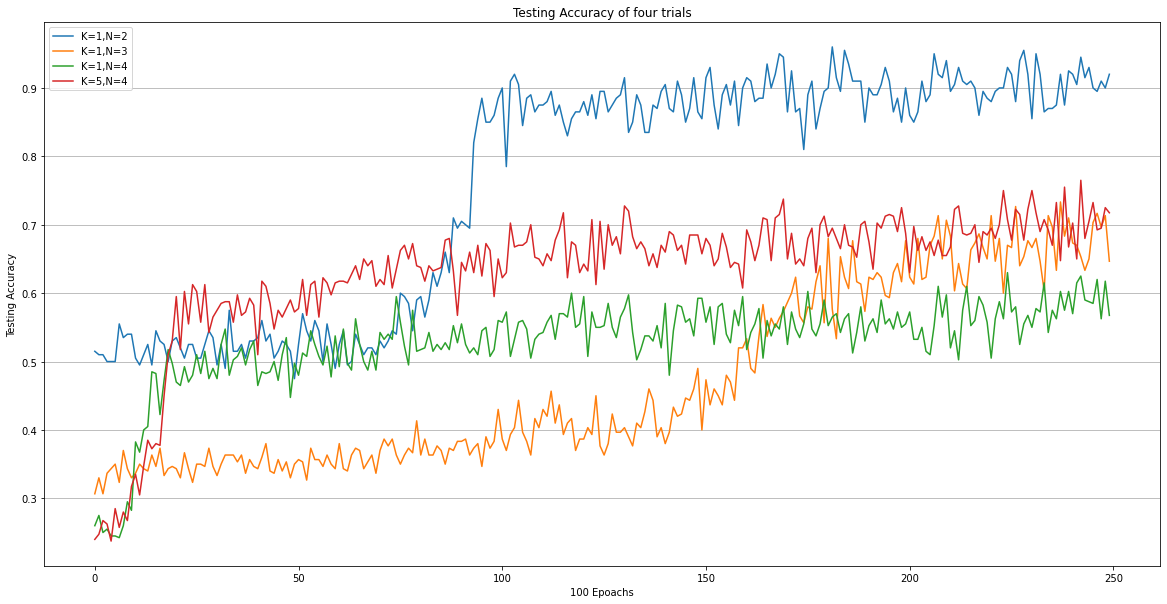

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(result1, label='K=1,N=2')
plt.plot(result2, label='K=1,N=3')
plt.plot(result3, label='K=1,N=4')
plt.plot(result4, label='K=5,N=4')
plt.legend()
plt.grid(which='both', axis='y')
plt.title('Testing Accuracy of four trials')
plt.xlabel('100 Epoachs')
plt.ylabel('Testing Accuracy')

## Problem 4
### 4A
The hyperparameter that I choose to tune one is: number of layers

Tryouts:
- Layer = 1
- Layer = 2 (original structure)
- Layer = 3

In [ ]:
# one layer model
class MANN_1layer(tf.keras.Model):

    def __init__(self, num_classes, samples_per_class):
        super(MANN_1layer, self).__init__()
        self.num_classes = num_classes
        self.samples_per_class = samples_per_class
        self.layer1 = tf.keras.layers.LSTM(num_classes, return_sequences=True)
        self.__getLabelMask__()
    
    def __getLabelMask__(self):
        mask = np.ones((self.samples_per_class,self.num_classes,self.num_classes))
        mask[self.samples_per_class-1,:,:] = 0
        self.label_mask = tf.constant(mask)

    def call(self, input_images, input_labels):
        """
        MANN
        Args:
            input_images: [B, K+1, N, 784] flattened images
            labels: [B, K+1, N, N] ground truth labels
        Returns:
            [B, K+1, N, N] predictions
        """
        # mask labels (during training time)
        train_mask = tf.repeat(tf.expand_dims(self.label_mask,axis=0),repeats=input_labels.shape[0],axis=0)
        train_labels = tf.math.multiply(input_labels, train_mask)
        # input tensor
        input_images = tf.cast(input_images, dtype='float64')
        input_4dim = tf.concat([input_images, train_labels], axis=3)
        three_dim_shape = (input_4dim.shape[0],input_4dim.shape[1]*input_4dim.shape[2],input_4dim.shape[3])
        input_3dim = tf.reshape(input_4dim, three_dim_shape)
        # calculations
        output_3dim = self.layer1(input_3dim)
        output_4dim = tf.reshape(output_3dim, input_labels.shape)
        return output_4dim

    def loss_function(self, preds, labels):
        """
        Computes MANN loss
        Args:
            preds: [B, K+1, N, N] network output
            labels: [B, K+1, N, N] labels
        Returns:
            scalar loss
        """
        # label tensor
        preds = tf.cast(preds, dtype='float64')
        lossFun = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        return lossFun(labels[:,-1,:,:], preds[:,-1,:,:])

# two layers model is just MANN

# three layers model
class MANN_3layers(tf.keras.Model):

    def __init__(self, num_classes, samples_per_class):
        super(MANN_3layers, self).__init__()
        self.num_classes = num_classes
        self.samples_per_class = samples_per_class
        self.layer1 = tf.keras.layers.LSTM(128, return_sequences=True)
        self.layer2 = tf.keras.layers.LSTM(64, return_sequences=True)
        self.layer3 = tf.keras.layers.LSTM(self.num_classes, return_sequences=True)
        self.__getLabelMask__()
    
    def __getLabelMask__(self):
        mask = np.ones((self.samples_per_class,self.num_classes,self.num_classes))
        mask[self.samples_per_class-1,:,:] = 0
        self.label_mask = tf.constant(mask)

    def call(self, input_images, input_labels):
        """
        MANN
        Args:
            input_images: [B, K+1, N, 784] flattened images
            labels: [B, K+1, N, N] ground truth labels
        Returns:
            [B, K+1, N, N] predictions
        """
        # mask labels (during training time)
        train_mask = tf.repeat(tf.expand_dims(self.label_mask,axis=0),repeats=input_labels.shape[0],axis=0)
        train_labels = tf.math.multiply(input_labels, train_mask)
        # input tensor
        input_images = tf.cast(input_images, dtype='float64')
        input_4dim = tf.concat([input_images, train_labels], axis=3)
        three_dim_shape = (input_4dim.shape[0],input_4dim.shape[1]*input_4dim.shape[2],input_4dim.shape[3])
        input_3dim = tf.reshape(input_4dim, three_dim_shape)
        # calculations
        a1 = self.layer1(input_3dim)
        a2 = self.layer2(a1)
        output_3dim = self.layer3(a2)
        output_4dim = tf.reshape(output_3dim, input_labels.shape)
        return output_4dim

    def loss_function(self, preds, labels):
        """
        Computes MANN loss
        Args:
            preds: [B, K+1, N, N] network output
            labels: [B, K+1, N, N] labels
        Returns:
            scalar loss
        """
        # label tensor
        preds = tf.cast(preds, dtype='float64')
        lossFun = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        return lossFun(labels[:,-1,:,:], preds[:,-1,:,:])

@tf.function
def train_step(images, labels, model, optim, eval=False):
    with tf.GradientTape() as tape:
        predictions = model(images, labels)
        loss = model.loss_function(predictions, labels)
    if not eval:
        gradients = tape.gradient(loss, model.trainable_variables)
        optim.apply_gradients(zip(gradients, model.trainable_variables))
    return predictions, loss

def main_v2(model, num_classes=5, num_samples=1, meta_batch_size=16, random_seed=1234):
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

    data_generator = DataGenerator(num_classes, num_samples + 1)

    o = model(num_classes, num_samples + 1)
    optim = tf.keras.optimizers.Adam(learning_rate=0.001)
    result = []
    for step in range(25000):
        input, label = data_generator.sample_batch('train', meta_batch_size)
        _, ls = train_step(input, label, o, optim)
        if (step + 1) % 100 == 0:
            print("*" * 5 + "Iter " + str(step + 1) + "*" * 5)
            input, label = data_generator.sample_batch('test', 100)
            pred, tls = train_step(input, label, o, optim, eval=True)
            print("Train Loss:", ls.numpy(), "Test Loss:", tls.numpy())
            pred = tf.reshape(pred, [-1, num_samples + 1, num_classes, num_classes])
            pred = tf.math.argmax(pred[:, -1, :, :], axis=2)
            label = tf.math.argmax(label[:, -1, :, :], axis=2)
            test_acc = tf.reduce_mean(tf.cast(tf.math.equal(pred, label), tf.float32)).numpy()
            result.append(test_acc)
            print("Test Accuracy", test_acc)
    return result

In [ ]:
# training: 1 layer model. K = 1, N = 3
import time
tik = time.time()
result5 = main_v2(MANN_1layer, num_classes=3, num_samples=1, meta_batch_size=64, random_seed=1234)
tok = time.time()
print("{} minutes".format((tok-tik)/60))

In [ ]:
# training: 3 layer model. K = 1, N = 3
import time
tik = time.time()
result6 = main_v2(MANN_3layers, num_classes=3, num_samples=1, meta_batch_size=64, random_seed=1234)
tok = time.time()
print("{} minutes".format((tok-tik)/60))

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(result5, label='layer = 1')
plt.plot(result2, label='layer = 2')
plt.plot(result6, label='layer = 3')
plt.legend()
plt.grid(which='both', axis='y')
plt.title('Testing Accuracy of three trials')
plt.xlabel('100 Epoachs')
plt.ylabel('Testing Accuracy')

### Observations

Using more `LSTM` layers in the model would incease the model's flexibility, meaning the model could learn more complex structures and tasks.

By choosing layers = `1, 2, 3`, from the testing accuracy plot, we can observe that the model of different layers performed differently:

Layers of the Model | Testing Accuracy
--- | ---
1 | $43.3\%$
2 | $65.3\%$
3 | $78.7\%$

The model performance increases with the number of layers, which indicates that task is more complicated for a one-layer or two-layer MANN model to study, trying higher number of layers may increase the predicting performance the model. And the final number of layer and be dicided through balancing the training time comsumption and the testing accuracy.

### 4B

Try changing the architecture of the model

In [ ]:
# three layers model
class MANN_new(tf.keras.Model):

    def __init__(self, num_classes, samples_per_class):
        super(MANN_new, self).__init__()
        self.num_classes = num_classes
        self.samples_per_class = samples_per_class
        self.layer1 = tf.keras.layers.Conv1D(128, 32, padding='same', activation='relu')
        self.layer2 = tf.keras.layers.Conv1D(64, 32, padding='same', activation='relu')
        forward_layer = tf.keras.layers.LSTM(self.num_classes, return_sequences=True)
        backward_layer = tf.keras.layers.LSTM(self.num_classes, activation='relu', 
                                              go_backwards=True, return_sequences=True)
        self.layer3 = tf.keras.layers.Bidirectional(forward_layer, 
                                                    merge_mode='sum',
                                                    backward_layer=backward_layer)
        self.__getLabelMask__()
    
    def __getLabelMask__(self):
        mask = np.ones((self.samples_per_class,self.num_classes,self.num_classes))
        mask[self.samples_per_class-1,:,:] = 0
        self.label_mask = tf.constant(mask)

    def call(self, input_images, input_labels):
        """
        MANN
        Args:
            input_images: [B, K+1, N, 784] flattened images
            labels: [B, K+1, N, N] ground truth labels
        Returns:
            [B, K+1, N, N] predictions
        """
        # mask labels (during training time)
        train_mask = tf.repeat(tf.expand_dims(self.label_mask,axis=0),repeats=input_labels.shape[0],axis=0)
        train_labels = tf.math.multiply(input_labels, train_mask)
        # input tensor
        input_images = tf.cast(input_images, dtype='float64')
        input_4dim = tf.concat([input_images, train_labels], axis=3)
        three_dim_shape = (input_4dim.shape[0],input_4dim.shape[1]*input_4dim.shape[2],input_4dim.shape[3])
        input_3dim = tf.reshape(input_4dim, three_dim_shape)
        # calculations
        a1 = self.layer1(input_3dim)
        a2 = self.layer2(a1)
        output_3dim = self.layer3(a2)
        output_4dim = tf.reshape(output_3dim, input_labels.shape)
        return output_4dim

    def loss_function(self, preds, labels):
        """
        Computes MANN loss
        Args:
            preds: [B, K+1, N, N] network output
            labels: [B, K+1, N, N] labels
        Returns:
            scalar loss
        """
        # label tensor
        preds = tf.cast(preds, dtype='float64')
        lossFun = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        return lossFun(labels[:,-1,:,:], preds[:,-1,:,:])

@tf.function
def train_step(images, labels, model, optim, eval=False):
    with tf.GradientTape() as tape:
        predictions = model(images, labels)
        loss = model.loss_function(predictions, labels)
    if not eval:
        gradients = tape.gradient(loss, model.trainable_variables)
        optim.apply_gradients(zip(gradients, model.trainable_variables))
    return predictions, loss

def main_v4(model, num_classes=5, num_samples=1, meta_batch_size=16, random_seed=1234):
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

    data_generator = DataGenerator(num_classes, num_samples + 1)

    o = model(num_classes, num_samples + 1)
    optim = tf.keras.optimizers.Adam(learning_rate=0.0002)
    result = []
    for step in range(20000):
        input, label = data_generator.sample_batch('train', meta_batch_size)
        _, ls = train_step(input, label, o, optim)
        if (step + 1) % 100 == 0:
            print("*" * 5 + "Iter " + str(step + 1) + "*" * 5)
            input, label = data_generator.sample_batch('test', 100)
            pred, tls = train_step(input, label, o, optim, eval=True)
            print("Train Loss:", ls.numpy(), "Test Loss:", tls.numpy())
            pred = tf.reshape(pred, [-1, num_samples + 1, num_classes, num_classes])
            pred = tf.math.argmax(pred[:, -1, :, :], axis=2)
            label = tf.math.argmax(label[:, -1, :, :], axis=2)
            test_acc = tf.reduce_mean(tf.cast(tf.math.equal(pred, label), tf.float32)).numpy()
            result.append(test_acc)
            print("Test Accuracy", test_acc)
    return result

In [ ]:
# train for 1-shot, 5-way task for 20000 epoch
tik = time.time()
result7 = main_v4(MANN_new, num_classes=5, num_samples=1, meta_batch_size=64, random_seed=2345)
tok = time.time()
print("{} minutes".format((tok-tik)/60))

Text(0, 0.5, 'Testing Accuracy')

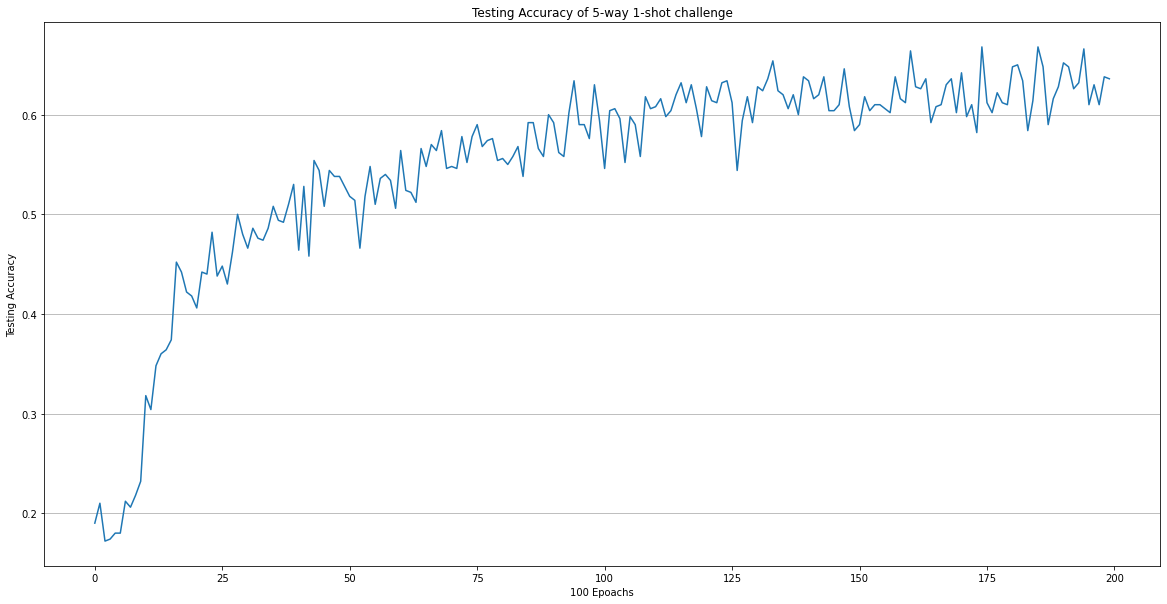

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(result7)
plt.grid(which='both', axis='y')
plt.title('Testing Accuracy of 5-way 1-shot challenge')
plt.xlabel('100 Epoachs')
plt.ylabel('Testing Accuracy')

#### Changes of Architecture
1. 1D convolutional layer $\times$ 2
2. Bi-directional LSTM layer 